In [ ]:
!pip install torch torch-geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 18.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 82.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 44.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 88.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 50.4 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12


In [67]:
import torch
import torch.nn.functional as F
from torch_geometric.data import Data
from torch_geometric.nn import SAGEConv
from torch_geometric.utils import negative_sampling

import matplotlib.pyplot as plt
import numpy as np
import networkx as nx

### Graph data generation

In [68]:
# Create simple clustered graph with 2D features
def create_graph_with_random_features(num_clusters=3, nodes_per_cluster=7, feature_dim=2):

    G = nx.Graph()
    cluster_offset = 0
    cluster_labels = []

    # Create clusters and add edges
    for c in range(num_clusters):
        cluster = nx.erdos_renyi_graph(nodes_per_cluster, p=0.8)
        mapping = {n: n + cluster_offset for n in cluster.nodes}
        cluster = nx.relabel_nodes(cluster, mapping)
        G = nx.compose(G, cluster)

        cluster_labels.extend([c] * nodes_per_cluster)
        cluster_offset += nodes_per_cluster

    # Add some inter-cluster edges
    for i in range(num_clusters):
        for j in range(i + 1, num_clusters):
            src = i * nodes_per_cluster + np.random.randint(nodes_per_cluster)
            dst = j * nodes_per_cluster + np.random.randint(nodes_per_cluster)
            G.add_edge(src, dst)

    # Random features initialization (unrelated to clusters)
    num_nodes = num_clusters * nodes_per_cluster
    node_features = np.random.randn(num_nodes, feature_dim)

    edge_index = torch.tensor(list(G.edges)).t().contiguous()
    x = torch.tensor(node_features, dtype=torch.float)
    y = torch.tensor(cluster_labels, dtype=torch.long)

    return G, Data(x=x, edge_index=edge_index), y

### GNN model definition

In [69]:
# GraphSAGE Model generating 8 features embedding per node
class GraphSAGE(torch.nn.Module):
    def __init__(self, in_channels=2, hidden_channels=8, out_channels=2):
        super().__init__()
        self.conv1 = SAGEConv(in_channels, hidden_channels)
        self.conv2 = SAGEConv(hidden_channels, out_channels)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        return x

#### Utils

In [70]:
# Visualization directly with 2D features/embeddings
def visualize_2d(z, epoch, labels, title_prefix="Node Embeddings"):
    z = z.detach().cpu().numpy()

    plt.clf()
    scatter = plt.scatter(z[:, 0], z[:, 1], c=labels.cpu().numpy(), cmap='tab10', s=100, edgecolors='k')
    for i, (x_, y_) in enumerate(z):
        plt.text(x_, y_, str(i), fontsize=8, ha='center', va='center', color='black')
    plt.title(f"{title_prefix} at Epoch {epoch}")
    plt.xlabel("Feature 1")
    plt.ylabel("Feature 2")
    plt.grid(True)
    plt.pause(0.3)

def visualize_graph_vs_embeddings(G, labels, final_embeddings):

    labels_np = labels.cpu().numpy()
    emb_np = final_embeddings.detach().cpu().numpy()

    # Precompute fixed graph layout positions
    graph_pos = nx.spring_layout(G, seed=42)

    if graph_pos is None:
        graph_pos = nx.spring_layout(G, seed=42)

    plt.figure(figsize=(12, 5))
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

    # Plot original graph structure
    nx.draw(
        G,
        pos=graph_pos,
        ax=ax1,
        node_color=labels_np,
        cmap='tab10',
        with_labels=True,
        node_size=300,
        edge_color='gray',
        font_color='black'
    )
    ax1.set_title("Original Graph (colored by true cluster)")

    # Plot final learned embeddings
    scatter = ax2.scatter(
        emb_np[:, 0], emb_np[:, 1],
        c=labels_np,
        cmap='tab10',
        s=100,
        edgecolors='k'
    )
    for i, (x_, y_) in enumerate(emb_np):
        ax2.text(x_, y_, str(i), fontsize=8, ha='center', va='center', color='black')
    ax2.set_title("Learned Node Embeddings (2D)")
    ax2.set_xlabel("Embedding dim 1")
    ax2.set_ylabel("Embedding dim 2")
    ax2.grid(True)

    plt.tight_layout()
    plt.show()

# Smoothing for loss plot
def smooth_curve(values, window_size=5):
    return np.convolve(values, np.ones(window_size)/window_size, mode='valid')

# Training loop
def train_and_visualize(epochs=100):
    loss_history = []

    plt.ion()
    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()

        z = model(data.x, data.edge_index)

        pos_edge_index = data.edge_index
        neg_edge_index = negative_sampling(
            edge_index=pos_edge_index,
            num_nodes=data.num_nodes,
            num_neg_samples=pos_edge_index.size(1)
        )

        pos_scores = (z[pos_edge_index[0]] * z[pos_edge_index[1]]).sum(dim=1)
        neg_scores = (z[neg_edge_index[0]] * z[neg_edge_index[1]]).sum(dim=1)

        loss = - (F.logsigmoid(pos_scores).mean() + F.logsigmoid(-neg_scores).mean())
        loss.backward()
        optimizer.step()
        loss_history.append(loss.item())

        if epoch % 50 == 0:
            print(f"Epoch {epoch:03d}, Loss: {loss.item():.4f}")
            model.eval()
            with torch.no_grad():
                z = model(data.x, data.edge_index)
            visualize_2d(z, epoch, labels)

    plt.ioff()
    plt.show()

    # Show raw features + graph before training
    final_embeddings = z
    visualize_graph_vs_embeddings(G, labels, final_embeddings)

    # Plot loss history
    smoothed_loss = smooth_curve(loss_history, window_size=5)
    plt.figure()
    plt.plot(loss_history, alpha=0.3, label="Raw Loss")
    plt.plot(range(len(smoothed_loss)), smoothed_loss, label="Smoothed Loss", linewidth=2)
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Loss History (Smoothed)")
    plt.grid(True)
    plt.legend()
    plt.show()

Epoch 000, Loss: 1.4062


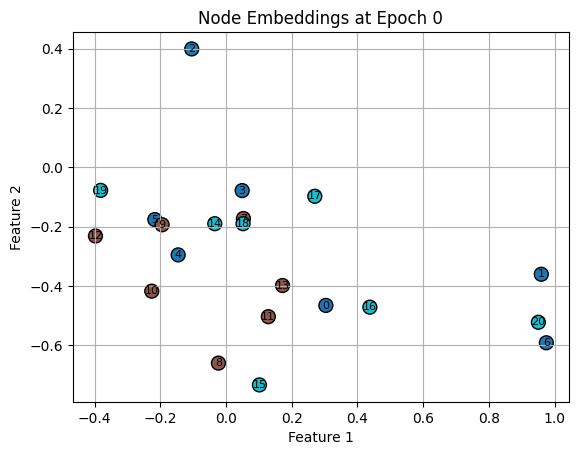

Epoch 050, Loss: 1.1501


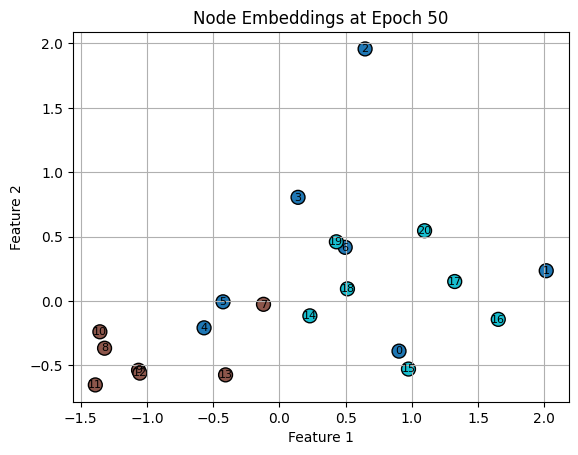

Epoch 100, Loss: 1.1422


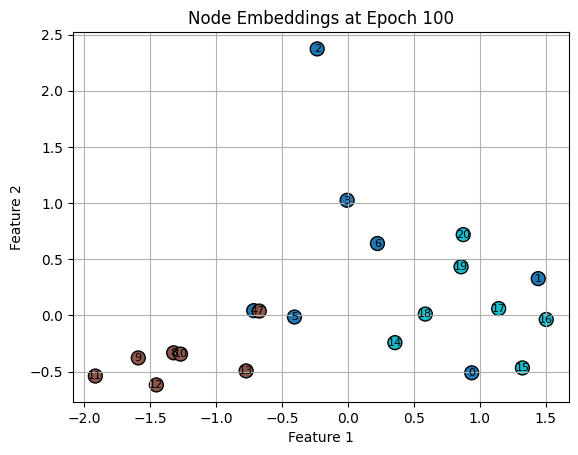

Epoch 150, Loss: 1.1029


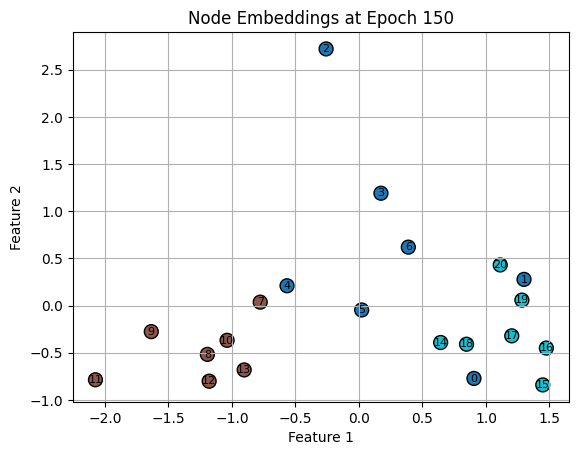

Epoch 200, Loss: 0.9667


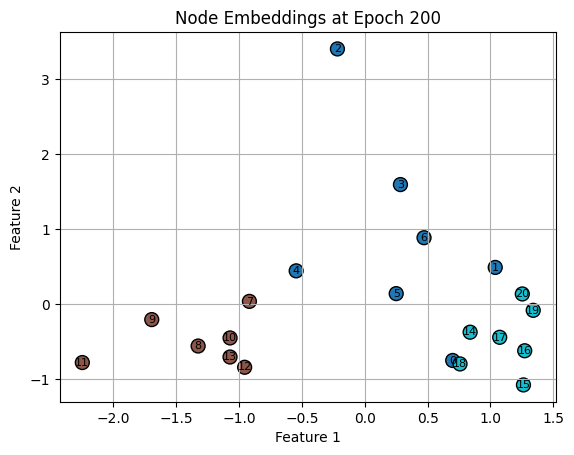

Epoch 250, Loss: 0.8721


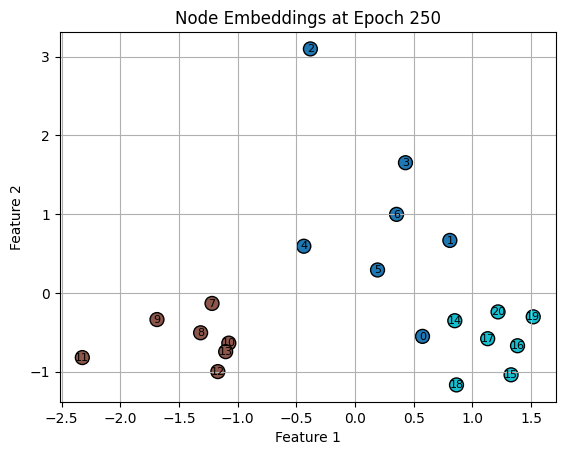

Epoch 300, Loss: 0.9539


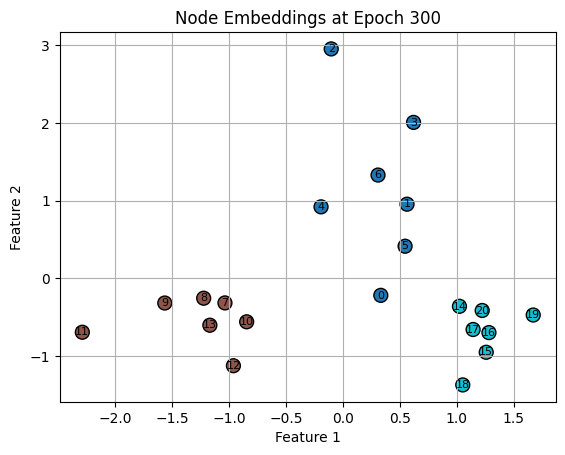

Epoch 350, Loss: 0.9398


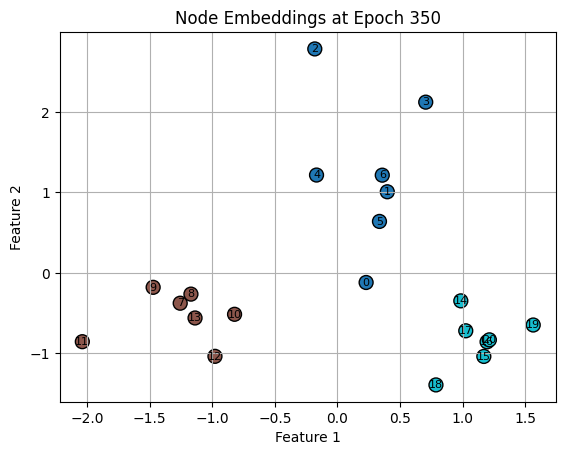

Epoch 400, Loss: 0.8790


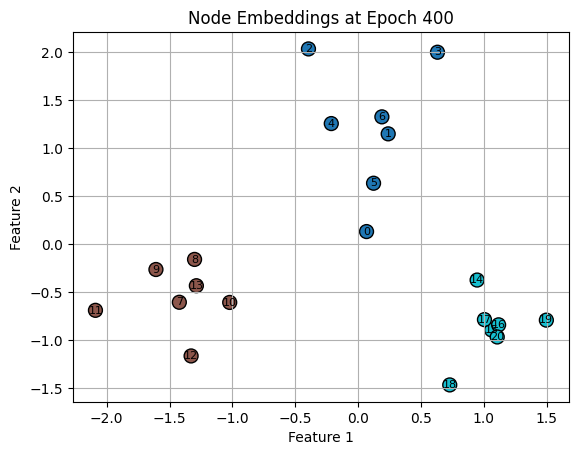

Epoch 450, Loss: 0.9022


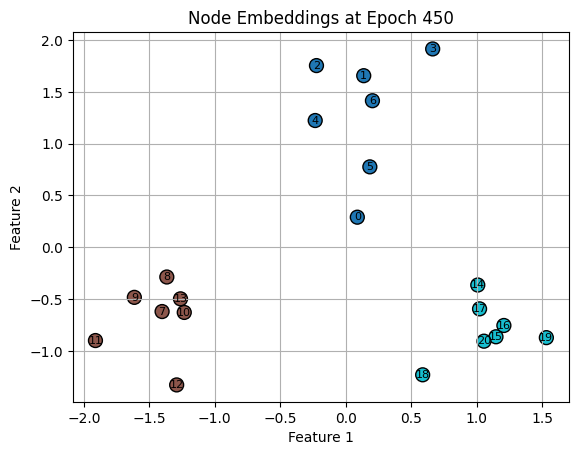

Epoch 500, Loss: 0.9159


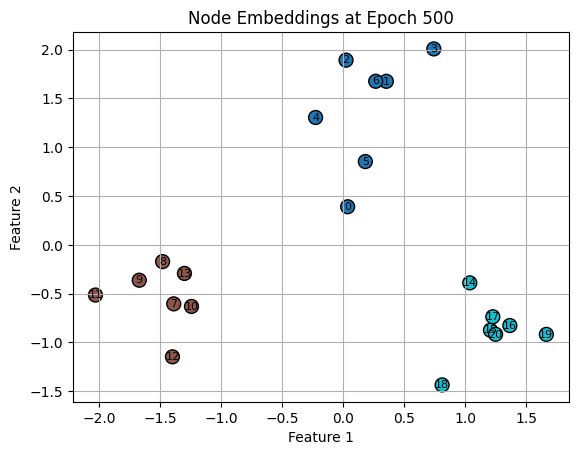

Epoch 550, Loss: 0.9607


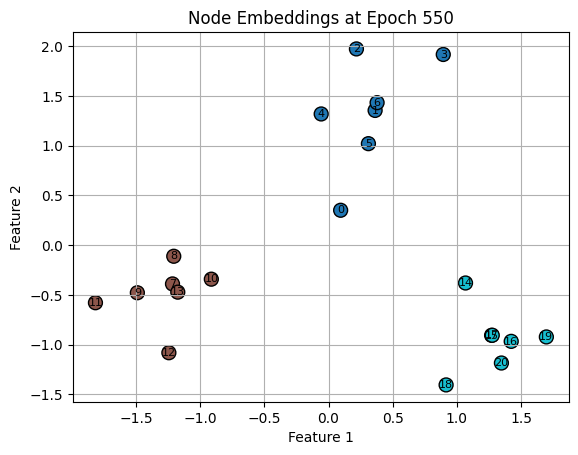

Epoch 600, Loss: 0.8705


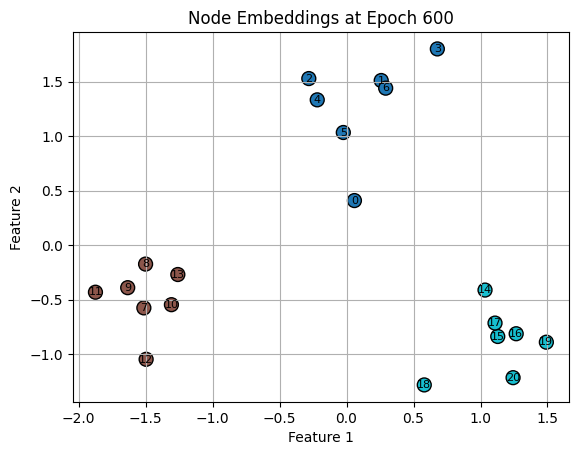

Epoch 650, Loss: 0.9429


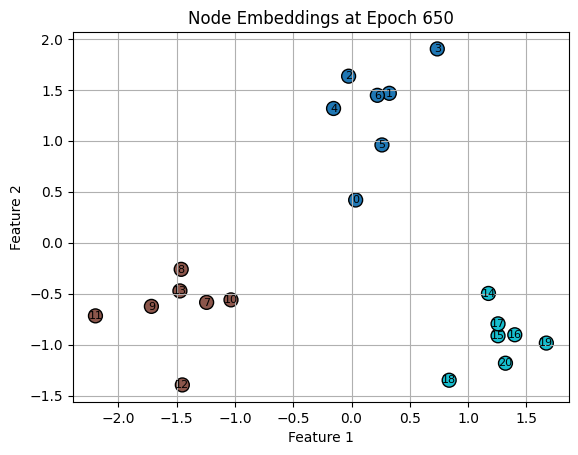

Epoch 700, Loss: 1.1011


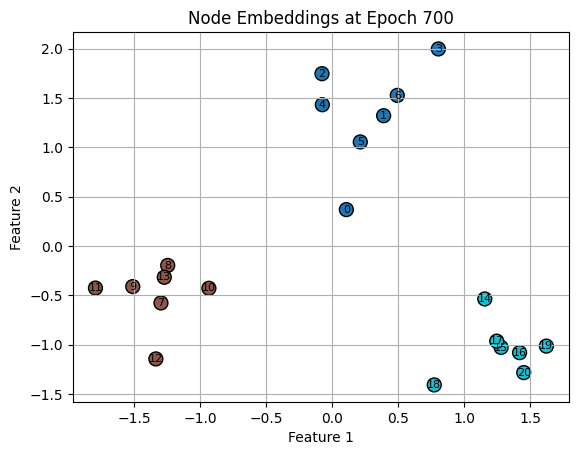

Epoch 750, Loss: 0.8297


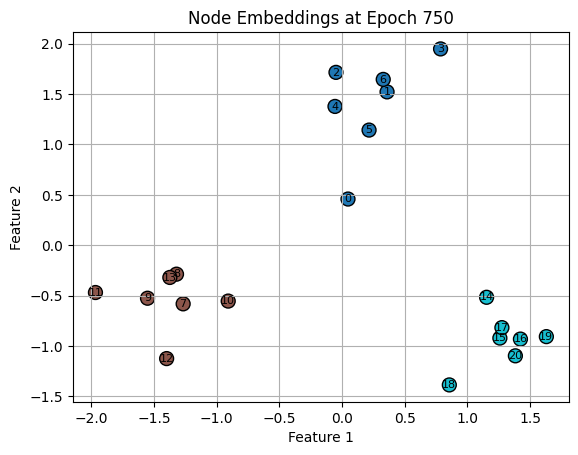

Epoch 800, Loss: 0.7758


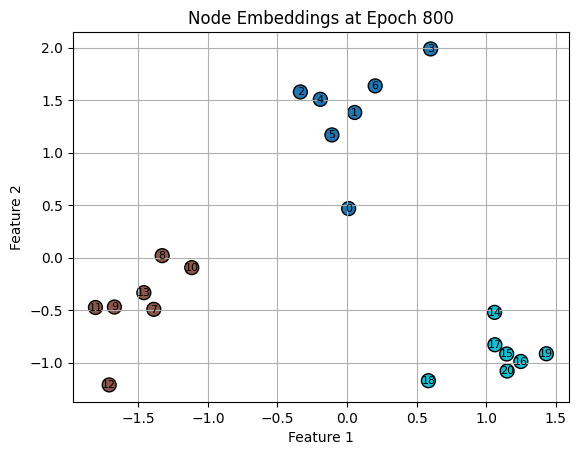

Epoch 850, Loss: 0.8431


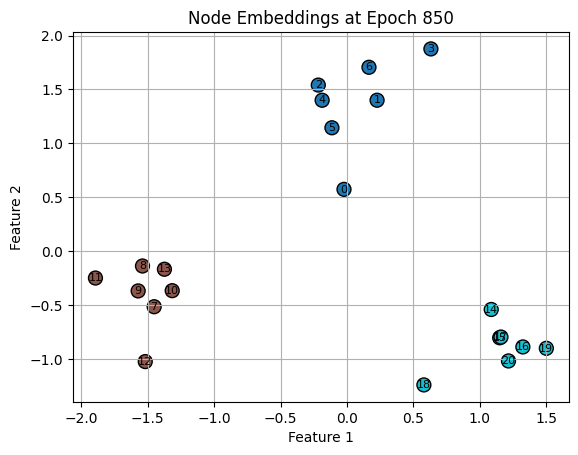

Epoch 900, Loss: 0.8886


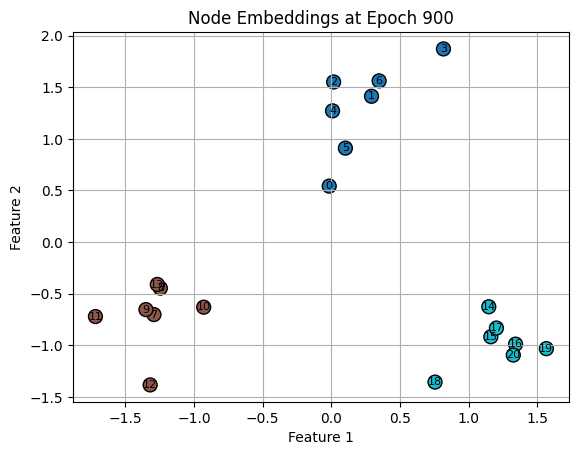

Epoch 950, Loss: 0.9753


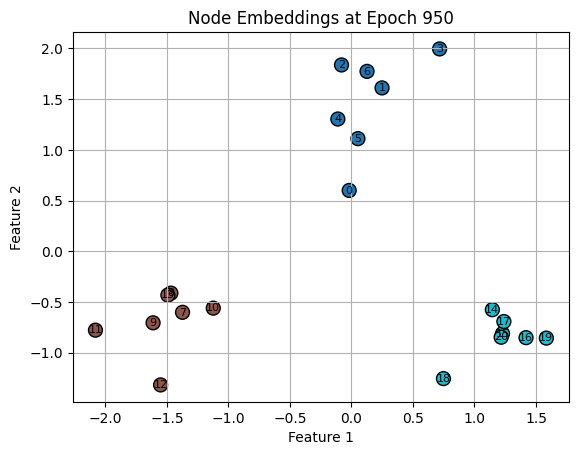

Epoch 1000, Loss: 0.8262


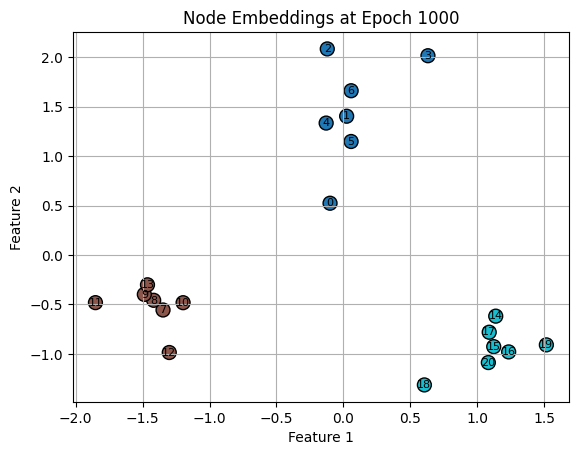

<Figure size 1200x500 with 0 Axes>

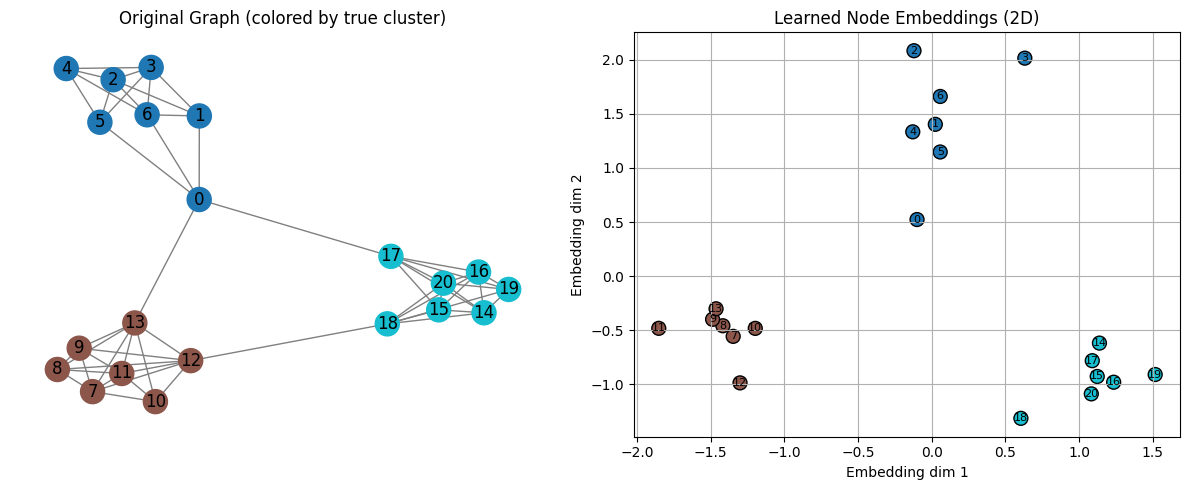

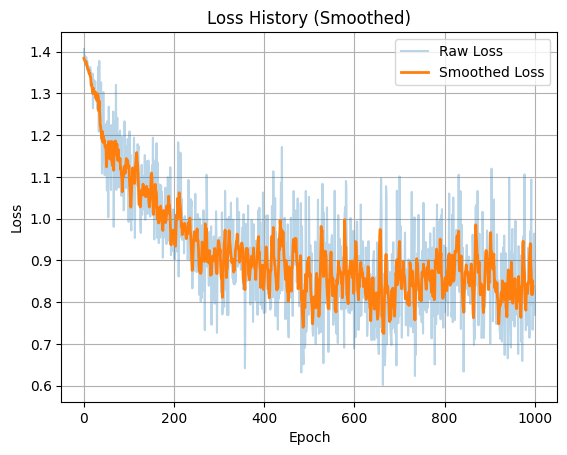

In [82]:
# Generate data
G, data, labels = create_graph_with_random_features(num_clusters=3, nodes_per_cluster=7)

# Instantiate model and hyperparameters
model = GraphSAGE()
optimizer = torch.optim.Adam(model.parameters(), lr=0.006)

# Train GNN and real-time visualize embedding learning
train_and_visualize(epochs=1001)